In [1]:
import os
import sys
import time
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
%matplotlib inline

In [59]:
PATH = 'data/'

In [80]:
# parameters
batch_size = 20
num_workers = 0
num_epochs = 100
learining_rate = 0.001

In [81]:
data_transformation = {
    'train' : transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'valid' : transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])        
    ]),
    
    'test' : transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])        
    ]),
}

In [82]:
dataset = {x: ImageFolder(os.path.join(PATH, x), data_transformation[x]) for x in ['train', 'valid', 'test']}

In [83]:
dataloader = {x: DataLoader(dataset[x], 
                            batch_size=batch_size, 
                            shuffle=True,  
                            num_workers=num_workers) for x in ['train', 'valid', 'test']}

In [84]:
train_loader, valid_loader, test_loader = dataloader['train'], dataloader['valid'], dataloader['test']

In [85]:
dataset_size = {x: len(dataset[x]) for x in ['train', 'valid', 'test']}
dataset_size

{'train': 7650, 'valid': 900, 'test': 450}

In [86]:
class_names = dataset['train'].classes
class_names

['blacksigatoka', 'fusariumwilt', 'healthy']

In [87]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

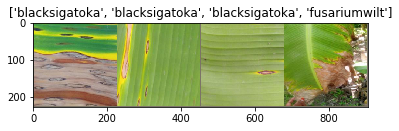

In [88]:
# Get a batch of training data
images, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in classes])

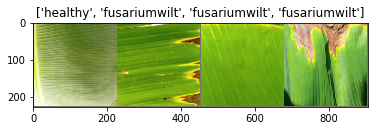

In [89]:
# Get a batch of training data
images, classes = next(iter(valid_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in classes])

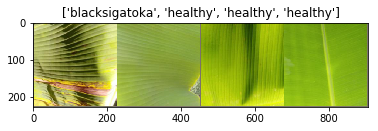

In [90]:
# Get a batch of training data
images, classes = next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in classes])

In [91]:
# model 
model =models.resnet34(pretrained=True)

In [92]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer 
optimizer = optim.SGD(model.parameters(), lr=learining_rate)

In [93]:
# train

In [94]:
image, label = next(iter(train_loader))
image.shape[1:]

torch.Size([3, 224, 224])

In [95]:
summary(model, (image.shape[1:]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Total params: 21,797,672
Trainable params: 21,797,672
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 96.29
Params size (MB): 83.15
Estimated Total Size (MB): 180.01
----------------------------------------------------------------


In [96]:
# fine tuning

In [97]:
num_features = model.fc.in_features
model.fc     = nn.Linear(num_features, 3)

In [98]:
num_features

512

In [99]:
output = model(image)
output

tensor([[ 0.5792, -0.5077, -0.1803],
        [-0.9466,  0.5062, -1.3529],
        [ 0.7605, -0.3742, -0.5086],
        [-0.2405,  0.2851, -0.2982]], grad_fn=<AddmmBackward>)

In [23]:
# train

In [ ]:
%%time

valid_loss_min = np.Inf

print('*' * 39)
print('Epoch \tTraining Loss \tValidation Loss')
for epoch in range(1, num_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
       
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        loss.backward()
        
        # update model parameters
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    # validate the model
    model.eval()
    for data, target in valid_loader:
      
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
      
        output = model(data)

        loss = criterion(output, target)
        
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
      
    # print training/validation statistics 
    print('{}\t\t{:.3f}\t\t{:.3f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'mandela.pt')
        valid_loss_min = valid_loss

***************************************
Epoch 	Training Loss 	Validation Loss
1		1.220		1.288
2		1.087		1.256
3		0.987		1.205


In [ ]:
# load model
model.load_state_dict(torch.load('mandela.pt'))

In [ ]:
# test
train_on_gpu = torch.cuda.is_available()

In [102]:
def testing(test_loader,batch_size ):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(3))
    class_total = list(0. for i in range(3))
    # specify the image classes
    classes = ['Balcksigatoka','fusariumwilt','healthy'] 

    model.eval()
    # iterate over test data
    for data, target in test_loader:
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # update test loss 
        test_loss += loss.item()*data.size(0)
        
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(3):
        if class_total[i] > 0:
            print('Test accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [ ]:
test(test_loader, batch_size)

In [ ]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
images.numpy()

if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model(images)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), 
                 color=("green" if preds[idx]==labels[idx].item() else "red"))